<a href="https://colab.research.google.com/github/irkian/Brain_Tumor_Classifier/blob/main/BrainTumorClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
projectName = 'BrainTumorClassification'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dataDir ='/content/drive/My Drive/Colab Notebooks/BrainTumorClassification'


In [7]:
print(os.listdir(dataDir))
classes = os.listdir(dataDir+'/Training')
print(classes)

['BrainTumorClassifier.ipynb', 'Testing', 'Training']
['pituitary', 'notumor', 'meningioma', 'glioma']


In [8]:
meningioma_train = os.listdir(dataDir+'/Training/meningioma')
print('No. of training data for meningioma: ', len(meningioma_train))

No. of training data for meningioma:  1339


In [9]:
meningioma_test = os.listdir(dataDir+'/Testing/meningioma')
print('No. of training data for meningioma: ', len(meningioma_test))

No. of training data for meningioma:  306


In [10]:
meningioma_test[:5]

['Te-meTr_0007.jpg',
 'Te-meTr_0008.jpg',
 'Te-meTr_0003.jpg',
 'Te-meTr_0009.jpg',
 'Te-me_0012.jpg']

In [11]:
glioma_train = os.listdir(dataDir+'/Training/glioma')
print('No. of training data for glioma: ', len(glioma_train))

No. of training data for glioma:  1321


In [12]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [15]:
trainDir = dataDir+'/Training'
testDir = dataDir+'/Testing'

trainDir, testDir

('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training',
 '/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing')

In [18]:
def walkThroughDir(dirPath):
  for dirpath, dirnames, filenames in os.walk(dirPath):
    print(f'There are {len(dirnames)} directories and {len(filenames)} image in "{dirpath}"')

In [19]:
walkThroughDir(dataDir)

There are 2 directories and 1 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification"
There are 4 directories and 0 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing"
There are 0 directories and 300 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma"
There are 0 directories and 405 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/notumor"
There are 0 directories and 306 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/meningioma"
There are 0 directories and 300 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/pituitary"
There are 4 directories and 0 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training"
There are 0 directories and 1457 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training/pituitary"
There are 0 directories and 1595 imag

In [37]:
import pathlib

imagePath=pathlib.PosixPath(imagePath)


In [38]:
imagePath

PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification')

Random image path: /content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training/pituitary/Tr-pi_0782.jpg
Image class: pituitary
Image height: 512
Image width: 512


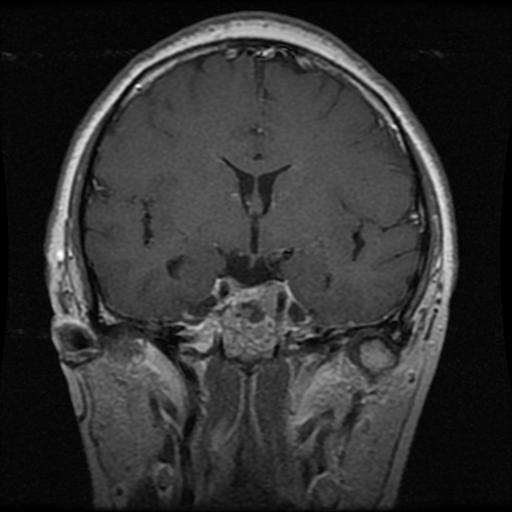

In [78]:
import random
from PIL import Image
# random.seed(42)

imagePathList= list(imagePath.glob("*/*/*.jpg"))


randomImagePath = random.choice(imagePathList)


imageClass = randomImagePath.parent.stem


img = Image.open(randomImagePath)

print(f'Random image path: {randomImagePath}')
print(f'Image class: {imageClass}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

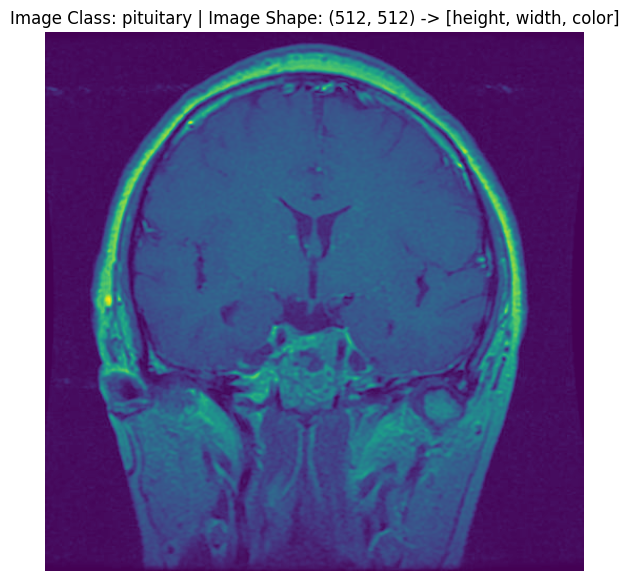

In [79]:
import numpy as np
import matplotlib.pyplot as plt

imageAsArray = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(imageAsArray)
plt.title(f'Image Class: {imageClass} | Image Shape: {imageAsArray.shape} -> [height, width, color]')
plt.axis(False);

In [80]:
imageAsArray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [83]:
#Transforming data with torchvision.transforms

dataTransform = transforms.Compose([
    #Resize our image
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [87]:
dataTransform(img)

tensor([[[0.0118, 0.0078, 0.0118,  ..., 0.0078, 0.0118, 0.0078],
         [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0275,  ..., 0.0275, 0.0235, 0.0275],
         ...,
         [0.0275, 0.0275, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0235, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0235],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0039]]])

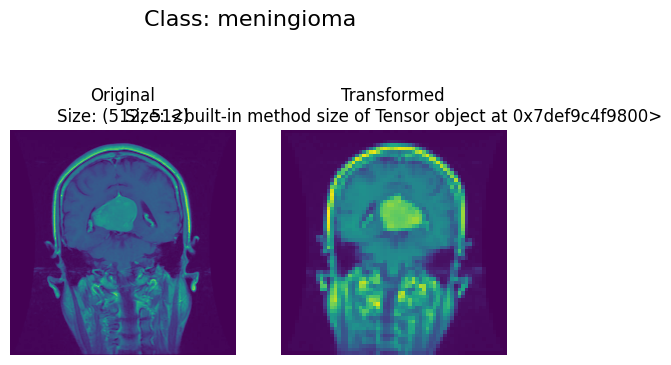

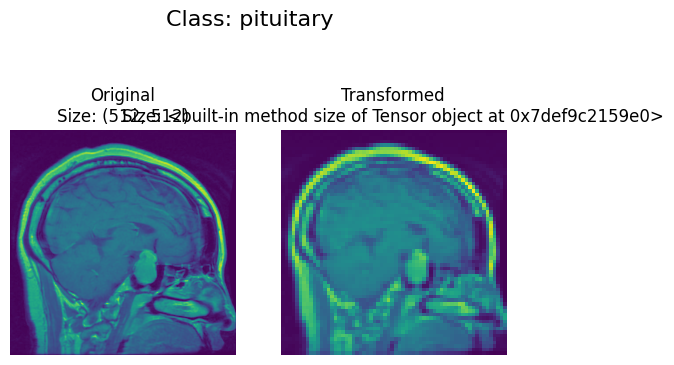

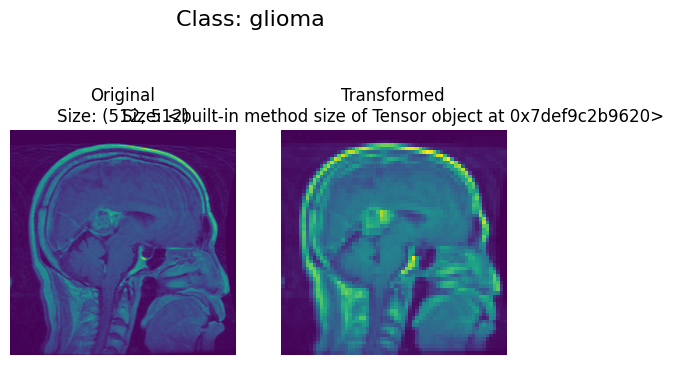

In [108]:
def plot_image(image_paths: list, transform, n=3, seed = None):
  if seed:
    random.seed(seed)
  randomImagePaths = random.sample(image_paths, k=n)
  for image_path in randomImagePaths:
    with Image.open(image_path) as f:
      fig , ax = plt.subplots(nrows=1,ncols =2 )
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nSize: {transformed_image.size}')
      ax[1].axis("off")

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize =16)


plot_image(image_paths=imagePathList,
           transform=dataTransform,
           n=3
           )


In [111]:
from torchvision import datasets

trainData = datasets.ImageFolder(root = trainDir,
                                 transform= dataTransform,
                                 target_transform=None)
testData = datasets.ImageFolder(root = testDir,
                                 transform= dataTransform
                               )
trainData, testData

(Dataset ImageFolder
     Number of datapoints: 5712
     Root location: /content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1311
     Root location: /content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [115]:
classNames = trainData.classes
classNames


['glioma', 'meningioma', 'notumor', 'pituitary']

In [116]:
classDict = trainData.class_to_idx
classDict

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [117]:
len(trainData), len(testData)

(5712, 1311)

In [122]:
img , label = trainData[0][0], trainData[0][1]

print(f'Image Tensor:\n {img}')
print(f'Image Shape:{img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatypes: {type(label)}')



Image Tensor:
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image Shape:torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatypes: <class 'int'>


Original Shape: torch.Size([3, 64, 64]) -> [color_channels, height, witdth]
Image permute: torch.Size([64, 64, 3]) -> [height, witdth,color_channels ]


Text(0.5, 1.0, 'glioma')

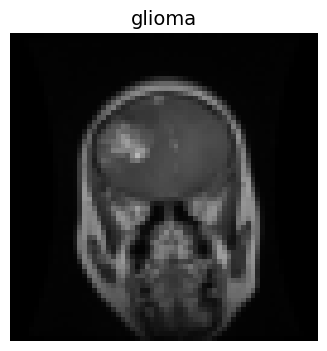

In [129]:
img_permute = img.permute(1,2,0)

print(f'Original Shape: {img.shape} -> [color_channels, height, witdth]')
print(f'Image permute: {img_permute.shape} -> [height, witdth,color_channels ]')

plt.figure(figsize=(8,4))
plt.imshow(img_permute)
plt.axis('off')
plt.title(classNames[label], fontsize = 14)

In [ ]:
#Data Loader

#Data Loader turns dataset into python iterables and turn data into mini batches

# computationally efficient, some somputer hardware may not be able to look at 60,000 images in one hit.
# it gives our neural network more chance to update its gradients per epoch

In [130]:
from torch.utils.data.dataloader import DataLoader

BatchSize = 32

trainDataLoader = DataLoader( dataset= trainData,
                             batch_size= BatchSize,
                              shuffle= True)
testDataLoader = DataLoader(dataset=testData,
                            batch_size=BatchSize,
                            shuffle=False)

trainDataLoader, testDataLoader

(<torch.utils.data.dataloader.DataLoader at 0x7def9c90a230>,
 <torch.utils.data.dataloader.DataLoader at 0x7def9c036140>)

In [131]:
print(f'DataLoaders: {trainDataLoader, testDataLoader}')
print(f'Length of train data loader : {len(trainDataLoader)} batches of {BatchSize}')
print(f'Length of test data loader : {len(testDataLoader)} batches of {BatchSize}')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7def9c90a230>, <torch.utils.data.dataloader.DataLoader object at 0x7def9c036140>)
Length of train data loader : 179 batches of 32
Length of test data loader : 41 batches of 32
